# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

In [2]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Data**

In [4]:
train_data_path = ('/content/drive/MyDrive/Colab Notebooks/Kaggle Codes /Fruits Classification/Data/Training')
val_data_path = ('/content/drive/MyDrive/Colab Notebooks/Kaggle Codes /Fruits Classification/Data/Validation')

In [5]:
test_data_path =('/content/drive/MyDrive/Colab Notebooks/Kaggle Codes /Fruits Classification/Data/Test')

# **Preprocess the Data**

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(100), # Zufällig zuschneiden, auf Größe skaliert
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [8]:
val_test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creating Data Loaders

In [9]:
train_data = datasets.ImageFolder(root=train_data_path, transform=transform)

val_data = datasets.ImageFolder(root=val_data_path, transform=val_test_transform)

test_data = datasets.ImageFolder(root=test_data_path, transform=val_test_transform)

In [10]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [11]:
num_classes = len(train_data.classes)
print('Number of Classes:', num_classes)
print('Labels:', train_data.classes)

Number of Classes: 24
Labels: ['apple_6', 'apple_braeburn_1', 'apple_crimson_snow_1', 'apple_golden_1', 'apple_golden_2', 'apple_golden_3', 'apple_granny_smith_1', 'apple_hit_1', 'apple_pink_lady_1', 'apple_red_1', 'apple_red_2', 'apple_red_3', 'apple_red_delicios_1', 'apple_red_yellow_1', 'apple_rotten_1', 'cabbage_white_1', 'carrot_1', 'cucumber_1', 'cucumber_3', 'eggplant_violet_1', 'pear_1', 'pear_3', 'zucchini_1', 'zucchini_dark_1']


# **Visualize Data**

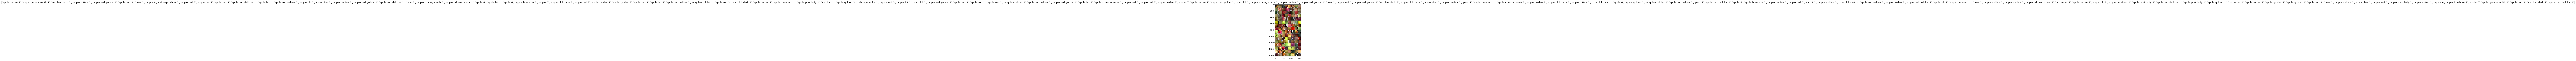

In [12]:
# Function to visualize a batch of images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[train_data.classes[x] for x in classes])

In [13]:
import random
from PIL import Image

def show_example_images(data_path, title, num_images=10, image_size=(100, 100)):
  class_names = os.listdir(data_path)
  fig, axes = plt.subplots(2, 5, figsize=(15,6))

  for i, ax in enumerate(axes.ravel()):  # Flaches Iterieren über die Achsen
        if i >= num_images:
            break

        random_class = random.choice(class_names)
        class_path = os.path.join(data_path, random_class)
        random_image = random.choice(os.listdir(class_path))

        img_path = os.path.join(class_path, random_image)
        img = Image.open(img_path)

        if img.size != image_size:
          img = img.resize(image_size)

        ax.imshow(img)
        ax.set_title(random_class)
        ax.axis('off')

  plt.suptitle(title, fontsize=16)
  plt.show()


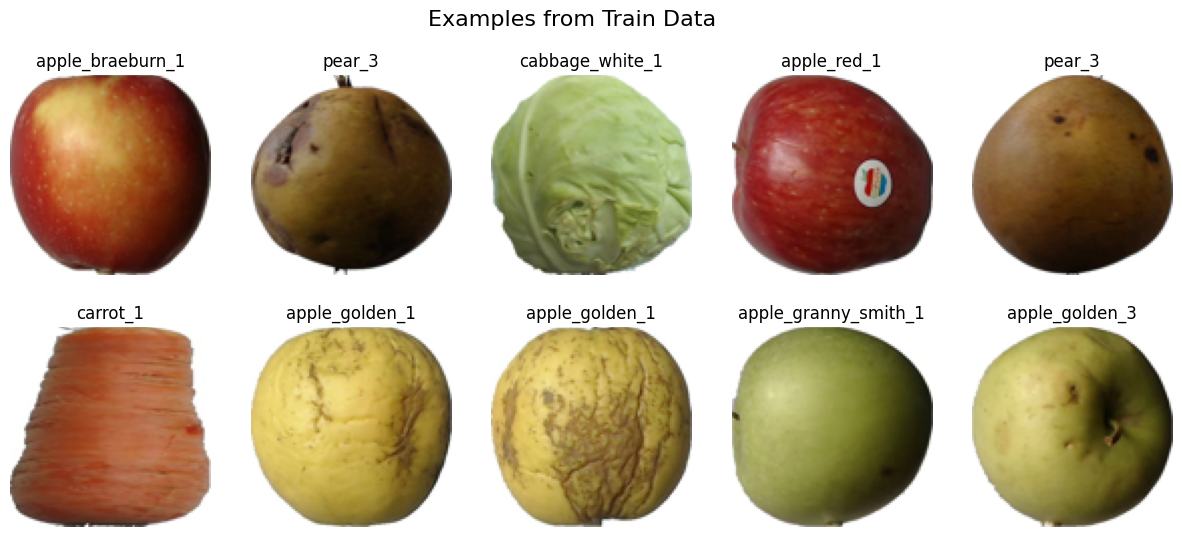

In [14]:
show_example_images(train_data_path, 'Examples from Train Data')

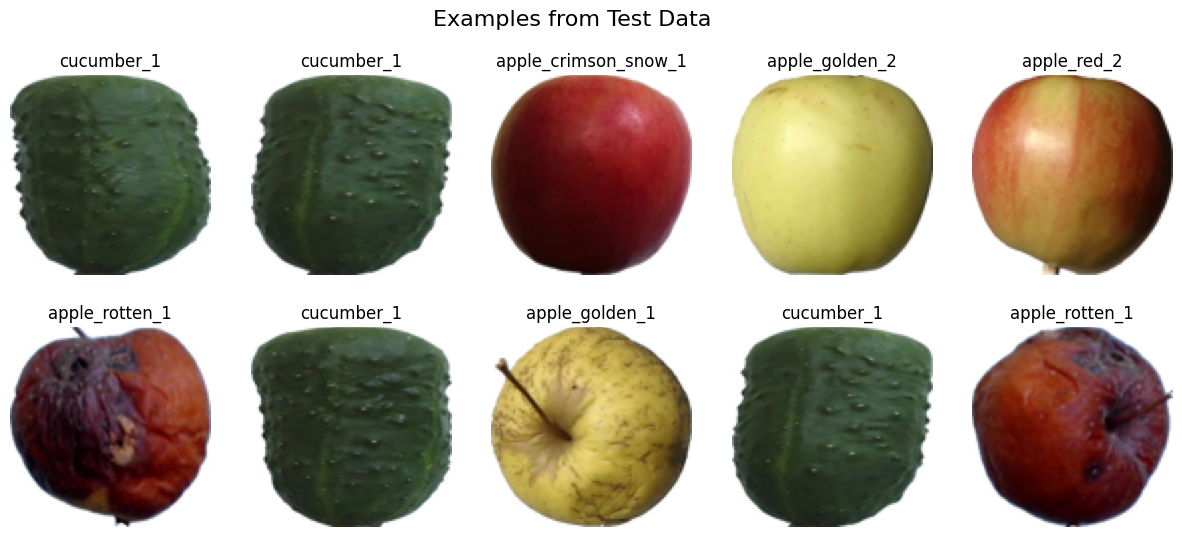

In [15]:
show_example_images(test_data_path, 'Examples from Test Data')

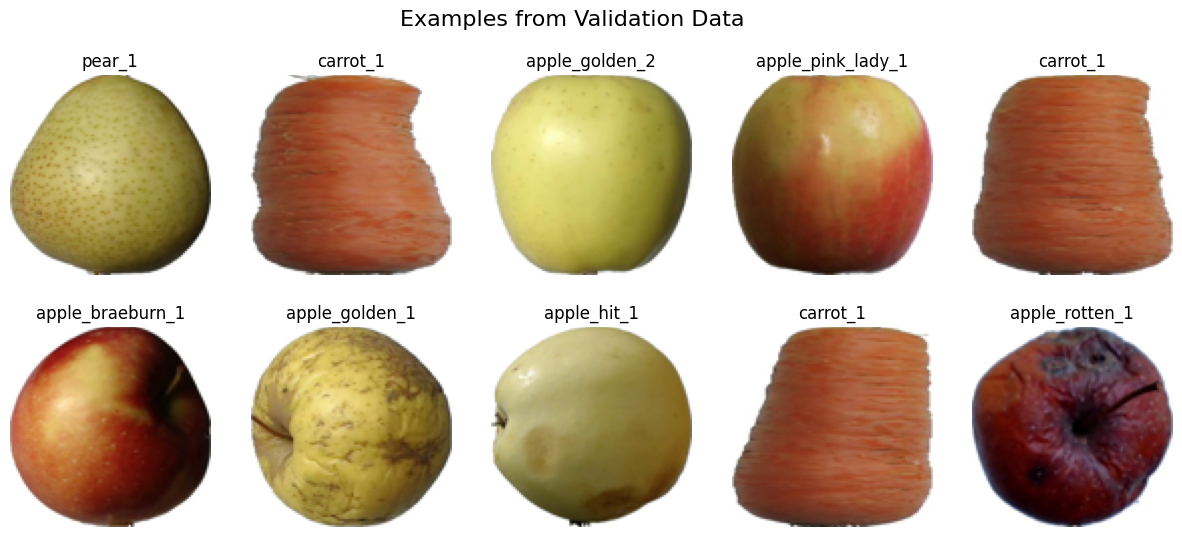

In [16]:
show_example_images(val_data_path, 'Examples from Validation Data')

# **Customer CNN Model**

In [17]:
class CustomerCNN(nn.Module):

  def __init__(self, num_classes):
    super(CustomerCNN, self).__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(output_size=(50, 50)),

    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(output_size=(25, 25)),

    )

    self.conv_block3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(output_size=(12, 12)),

    )

    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256 * 12 * 12, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes),
    )

  def forward(self, x):
      x = self.conv_block1(x)
      x = self.conv_block2(x)
      x = self.conv_block3(x)
      x = self.fc(x)
      return x

## Training

In [18]:
cnn_model = CustomerCNN(num_classes).to(device)
optimizer = optim.RMSprop(cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [19]:
epochs = 20

train_loss_history, val_loss_history = [], []

train_acc_history, val_acc_history = [], []


In [20]:
for epoch in range(epochs):
  cnn_model.train()
  train_loss, train_correct = 0, 0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()


    outputs = cnn_model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_correct += (outputs.argmax(1) == labels).sum().item()

  train_loss /= len(train_loader)
  train_accuracy = train_correct / len(train_data)
  train_loss_history.append(train_loss)
  train_acc_history.append(train_accuracy)

    # Validation
  cnn_model.eval()
  val_loss, val_correct = 0, 0

  with torch.no_grad():
      for images, labels in val_loader:
          images, labels = images.to(device), labels.to(device)

          outputs = cnn_model(images)
          loss = criterion(outputs, labels)

          val_loss += loss.item()
          val_correct += (outputs.argmax(1) == labels).sum().item()

  val_loss /= len(val_loader)
  val_accuracy = val_correct / len(val_data)
  val_loss_history.append(val_loss)
  val_acc_history.append(val_accuracy)

  print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")



Epoch 1/20, Train Loss: 14.7221, Train Acc: 0.1123, Val Loss: 3.6825, Val Acc: 0.0925
Epoch 2/20, Train Loss: 2.5502, Train Acc: 0.1966, Val Loss: 4.2000, Val Acc: 0.0899
Epoch 3/20, Train Loss: 2.3520, Train Acc: 0.2409, Val Loss: 2.2412, Val Acc: 0.2373
Epoch 4/20, Train Loss: 2.2709, Train Acc: 0.2499, Val Loss: 2.5798, Val Acc: 0.2193
Epoch 5/20, Train Loss: 2.2164, Train Acc: 0.2784, Val Loss: 3.2200, Val Acc: 0.1863
Epoch 6/20, Train Loss: 2.1710, Train Acc: 0.2852, Val Loss: 2.4408, Val Acc: 0.2486
Epoch 7/20, Train Loss: 2.0963, Train Acc: 0.3056, Val Loss: 2.1728, Val Acc: 0.2486
Epoch 8/20, Train Loss: 2.0565, Train Acc: 0.3181, Val Loss: 1.6284, Val Acc: 0.3821
Epoch 9/20, Train Loss: 2.0209, Train Acc: 0.3325, Val Loss: 2.0655, Val Acc: 0.3076
Epoch 10/20, Train Loss: 2.0074, Train Acc: 0.3320, Val Loss: 2.5221, Val Acc: 0.2425
Epoch 11/20, Train Loss: 1.9470, Train Acc: 0.3564, Val Loss: 1.8894, Val Acc: 0.3198
Epoch 12/20, Train Loss: 1.9346, Train Acc: 0.3489, Val Loss: 

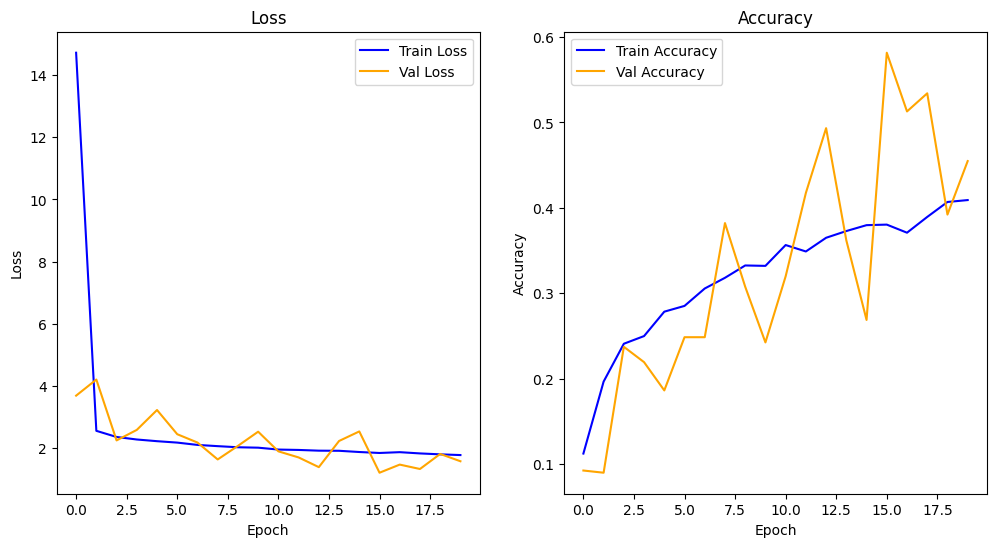

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Train Loss", color="blue")
plt.plot(val_loss_history, label="Val Loss", color="orange")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label="Train Accuracy", color="blue")
plt.plot(val_acc_history, label="Val Accuracy", color="orange")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

## Evaluation

In [22]:
cnn_model.eval()
test_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        test_correct += (outputs.argmax(1) == labels).sum().item()

test_accuracy = test_correct / len(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.4540


# **Implementing VGG16 Model**

In [25]:
vgg_model = models.vgg16(pretrained=True)

for param in vgg_model.parameters():
  param.requires_grad = True #


vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features,
                                    num_classes)
vgg_model = vgg_model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 219MB/s]


In [26]:
optimizer_vgg = optim.Adam(vgg_model.parameters(), lr=0.0001)
criterion_vgg = nn.CrossEntropyLoss()

## Training

In [27]:
epochs = 5
train_loss_history_vgg, val_loss_history_vgg = [], []
train_acc_history_vgg, val_acc_history_vgg = [], []

In [28]:
for epoch in range(epochs):
  vgg_model.train()
  train_loss, train_correct = 0, 0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer_vgg.zero_grad()

    outputs = vgg_model(images)
    loss = criterion_vgg(outputs, labels)
    loss.backward()
    optimizer_vgg.step()


    train_loss += loss.item()
    train_correct += (outputs.argmax(1) == labels).sum().item()

  train_loss /= len(train_loader)
  train_accuracy = train_correct / len(train_data)
  train_loss_history_vgg.append(train_loss)
  train_acc_history_vgg.append(train_accuracy)


## Evaluation

In [29]:
vgg_model.eval()
val_loss, val_correct = 0, 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = vgg_model(images)
        loss = criterion_vgg(outputs, labels)

        val_loss += loss.item()
        val_correct += (outputs.argmax(1) == labels).sum().item()

val_loss /= len(val_loader)
val_accuracy = val_correct / len(val_data)
val_loss_history.append(val_loss)
val_acc_history.append(val_accuracy)

print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

Epoch 5/5, Train Loss: 0.1782, Train Acc: 0.9440, Val Loss: 0.0653, Val Acc: 0.9788
